## Seq2Seq Architectures

The CTC models discussed in the previous section used only the encoder part of the transformer architecture. When we also add the decoder to create an encoder-decoder model, this is referred to as a sequence-to-sequence model or seq2seq for short. The model maps a sequence of one kind of data to a sequence of another kind of data.

With encoder-only transformer models, the encoder made a prediction for each element in the input sequence. Therefore, both input and output sequences will always have the same length. In the case of CTC models such as Wav2Vec2 the input waveform was first downsampled, but there still was one prediction for every 20 ms of audio.

With a seq2seq model, there is no such one-to-one correspondence and the input and output sequences can have different lengths. That makes seq2seq models suitable for NLP tasks such as text summarization or translation between different languages — but also for audio tasks such as speech recognition.

The architecture of a decoder is very similar to that of an encoder, and both use similar layers with self-attention as the main feature. However, the decoder performs a different task than the encoder. To see how this works, let’s examine how a seq2seq model can do automatic speech recognition.

#### Automatic speech recognition


The architecture of Whisper is as follows (figure courtesy of OpenAI Whisper blog): https://openai.com/blog/whisper/

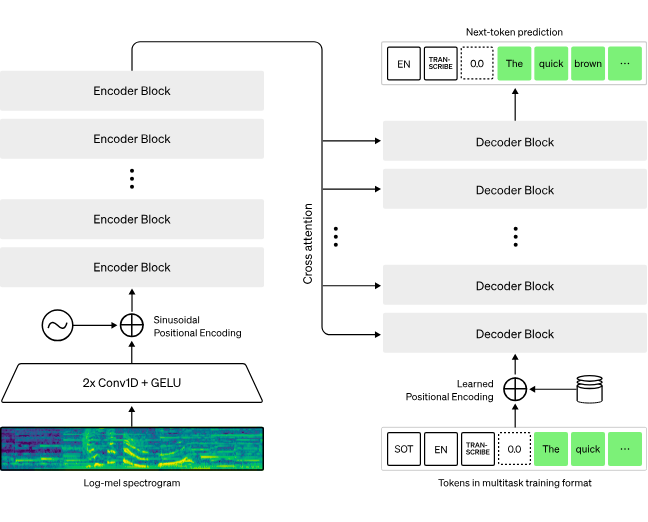

On the left is the transformer encoder. This takes as input a log-mel spectrogram and encodes that spectrogram to form a sequence of encoder hidden states that extract important features from the spoken speech. This hidden-states tensor represents the input sequence as a whole and effectively encodes the “meaning” of the input speech.

##### Note:
It's common for these seq2seq models to use spectrograms as input. However, a seq2seq model can also be designed to work directly on audio waveforms.

The output of the encoder is then passed into the transformer decoder, shown on the right, using a mechanism called cross-attention. This is like self-attention but attends over the encoder output. From this point on, the encoder is no longer needed.

The decoder predicts a sequence of text tokens in an autoregressive manner, a single token at a time, starting from an initial sequence that just has a “start” token in it (SOT in the case of Whisper). At each following timestep, the previous output sequence is fed back into the decoder as the new input sequence. In this manner, the decoder emits one new token at a time, steadily growing the output sequence, until it predicts an “end” token or a maximum number of timesteps is reached.

While the architecture of the decoder is mostly identical to that of the encoder, there are two big differences:

1. the decoder has a cross-attention mechanism that allows it to look at the encoder’s representation of the input sequence
2. the decoder’s attention is causal — the decoder isn’t allowed to look into the future.

In this design, the decoder plays the role of a language model, processing the hidden-state representations from the encoder and generating the corresponding text transcriptions. This is a more powerful approach than CTC, even if the CTC model is combined with an external language model, as the seq2seq system can be trained end-to-end with the same training data and loss function, giving greater flexibility and generally superior performance.

Whereas a CTC model outputs a sequence of individual characters, the tokens predicted by Whisper are full words or portions of words. It uses the tokenizer from GPT-2 and has 50k+ unique tokens. A seq2seq model can therefore output a much shorter sequence than a CTC model for the same transcription.

A typical loss function for a seq2seq ASR model is the cross-entropy loss, as the final layer of the model predicts a probability distribution over the possible tokens. This is usually combined with techniques such as beam search to generate the final sequence. The metric for speech recognition is WER or word error rate, which measures how many substitutions, insertions, and deletions are necessary to turn the predicted text into the target text — the fewer, the better the score.

#### Text-to-speech

A seq2seq model for TTS works essentially the same as described above but with the inputs and outputs switched around! The transformer encoder takes in a sequence of text tokens and extracts a sequence of hidden-states that represent the input text. The transformer decoder applies cross-attention to the encoder output and predicts a spectrogram.

Recall that a spectrogram is made by taking the frequency spectrum of successive time slices of an audio waveform and stacking them together. In other words, a spectrogram is a sequence where the elements are (log-mel) frequency spectra, one for each timestep.

With the ASR model, the decoder was kickstarted using a sequence that just has the special “start” token in it. For the TTS model, we can start the decoding with a spectrogram of length one that is all zeros that acts as the “start token”. Given this initial spectrogram and the cross-attentions over the encoder’s hidden-state representations, the decoder then predicts the next timeslice for this spectrogram, steadily growing the spectrogram one timestep at a time.



With the ASR model, the decoder was kickstarted using a sequence that just has the special “start” token in it. For the TTS model, we can start the decoding with a spectrogram of length one that is all zeros that acts as the “start token”. Given this initial spectrogram and the cross-attentions over the encoder’s hidden-state representations, the decoder then predicts the next timeslice for this spectrogram, steadily growing the spectrogram one timestep at a time.

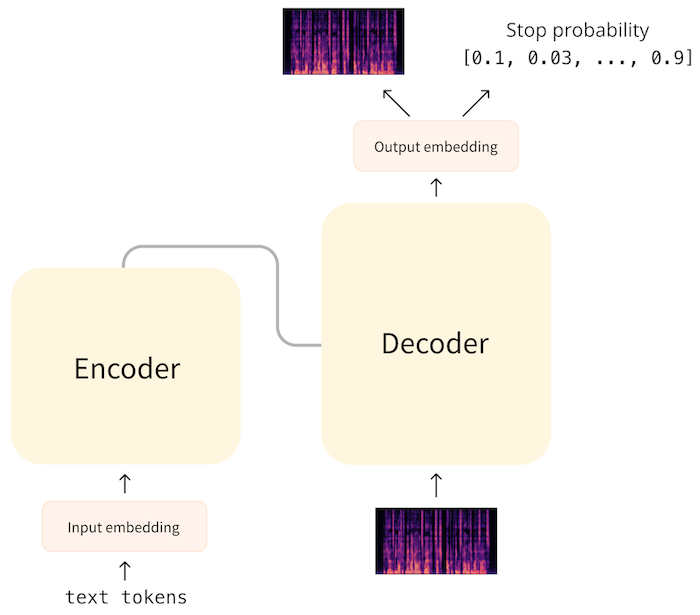

But how does the decoder know when to stop? In the SpeechT5 model this is handled by making the decoder predict a second sequence. This contains the probability that the current timestep is the last one. While generating audio at inference time, if this probability is over a certain threshold (say 0.5), the decoder is indicating that the spectrogram is finished and the generation loop should end.

After the decoding finishes and we have an output sequence containing the spectrogram, SpeechT5 uses a so-called post-net that is made up of several convolution layers to refine the spectrogram.

During training of the TTS model, the targets are also spectrograms and the loss is L1 or MSE. At inference time we want to convert the output spectrogram into an audio waveform, so that we can actually listen to it. For this an external model is used, the vocoder. This vocoder is not part of the seq2seq architecture and is trained separately.

What makes TTS difficult is that it’s a one-to-many mapping. With speech-to-text there is only one correct output text that corresponds to the input speech, but with text-to-speech the input text can be mapped to many possible speech sounds. Different speakers may choose to emphasize different parts of the sentence, for example. This makes TTS models hard to evaluate. Because of this, the L1 or MSE loss value isn’t actually very meaningful — there are multiple ways to represent the same text to a spectrogram. This is why TTS models are typically evaluated by human listeners, using a metric known as MOS or mean opinion score.

### Conclusion
The seq2seq approach is more powerful than an encoder-only model. By separating the encoding of the input sequence from the decoding of the output sequence, the alignment of audio and text is less of a problem.

However, an encoder-decoder model is also slower as the decoding process happens one step at a time, rather than all at once. The longer the sequence, the slower the prediction. Autoregressive models can also get stuck in repetitions or skip words. Techniques such as beam search can help improve the quality of the predictions, but also slow down decoding even more.